<a href="https://colab.research.google.com/github/Mbigdeli2003/RL_training/blob/main/RL_session2_TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classes:
Classes are templates that allow us to implement a reinforcement learning agent in an object-oriented manner. Each class can have properties such as the state, actions, and policy.

Example: Suppose we want to define a Q-learning agent. The "QAgent" class can have properties like the Q-table and methods such as action selection or Q-table updates.

Objects:
Objects are instances of classes. When we use a class to create a new reinforcement learning agent, this agent inherits all the properties and methods defined in the class and can interact with the environment.

Example: If we define a class called "QAgent," each instance of this class will represent a new learning agent that interacts with the Gym environment.

Methods:
Methods are functions defined inside a class that allow objects to operate on their data or properties. In reinforcement learning, methods usually include processes like action selection or Q-value updates.

Example: A method responsible for selecting an action based on the ε-greedy policy could be a method within the "QAgent" class.

Constructors:
Constructors are methods that are called when a new object is created from a class. In reinforcement learning, the constructor can be used to initialize features like the Q-table and learning rate.

Example: In the "QAgent" class, the constructor could be used to define initial parameters such as the learning rate and the Q-table.

Inheritance:
Inheritance allows us to create a new agent (class) based on an existing agent (class) and inherit all of its properties and methods. In reinforcement learning, this helps us create new algorithms based on existing ones.

Example: Suppose a class "DeepQAgent" is inherited from the "QAgent" class. The difference is that "DeepQAgent" uses neural networks for learning instead of a Q-table.

Episode 0: Total Reward = -4.999999999999998, Average Reward = -4.999999999999998
Episode 100: Total Reward = 0.5, Average Reward = 0.16138613861386142
Episode 200: Total Reward = 0.5, Average Reward = 0.2348258706467662
Episode 300: Total Reward = -0.09999999999999987, Average Reward = 0.24983388704318937
Episode 400: Total Reward = 0.5, Average Reward = 0.2571072319201995
Episode 500: Total Reward = 0.5, Average Reward = 0.2590818363273453
Episode 600: Total Reward = 0.10000000000000009, Average Reward = 0.26106489184692183
Episode 700: Total Reward = 0.20000000000000007, Average Reward = 0.26462196861626247
Episode 800: Total Reward = -0.30000000000000004, Average Reward = 0.2614232209737828
Episode 900: Total Reward = 0.5, Average Reward = 0.2632630410654828


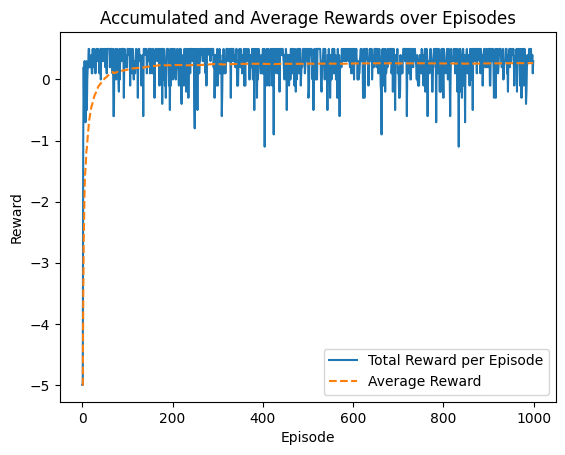

Policy after training:
→ ↓ ↓ ↓
↓ → → ↓
→ → → ↓
→ → → ↑
Q-values after training:


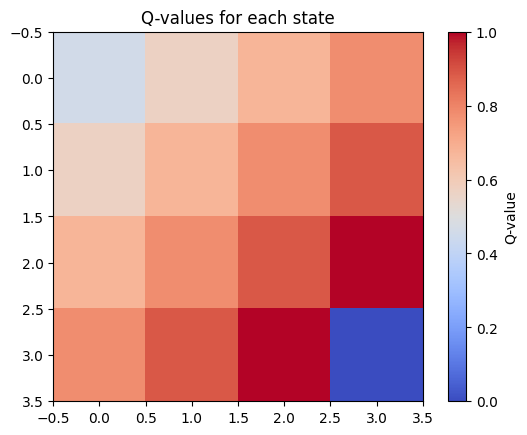

In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

# Custom GridWorld environment using OpenAI Gym
class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=4):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.agent_pos = [0, 0]  # Agent starts at the top-left corner
        self.goal_pos = [grid_size - 1, grid_size - 1]  # Goal is at the bottom-right corner

        # Define action space: 0=Up, 1=Right, 2=Down, 3=Left
        self.action_space = spaces.Discrete(4)

        # Observation space: Agent's position (2D coordinate) on the grid
        self.observation_space = spaces.Box(low=0, high=grid_size - 1, shape=(2,), dtype=np.int32)

    def reset(self):
        # Reset agent's position to the starting point (top-left)
        self.agent_pos = [0, 0]
        return np.array(self.agent_pos)

    def step(self, action):
        # Move agent based on the action chosen (Up, Right, Down, Left)
        if action == 0 and self.agent_pos[0] > 0:  # Up
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[1] < self.grid_size - 1:  # Right
            self.agent_pos[1] += 1
        elif action == 2 and self.agent_pos[0] < self.grid_size - 1:  # Down
            self.agent_pos[0] += 1
        elif action == 3 and self.agent_pos[1] > 0:  # Left
            self.agent_pos[1] -= 1

        # Check if agent has reached the goal
        done = self.agent_pos == self.goal_pos
        reward = 1 if done else -0.1  # Reward 1 for reaching goal, -0.1 penalty per step

        return np.array(self.agent_pos), reward, done, {}

    def render(self, mode="human"):
        # Create a grid and print it out, marking the agent and goal
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '-'
        grid[tuple(self.goal_pos)] = 'G'
        grid[tuple(self.agent_pos)] = 'A'
        print("\n".join([" ".join(row) for row in grid]))
        print()

# Q-learning Agent
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.5, gamma=0.99, epsilon=0.3):
        # Initialize parameters for the Q-learning algorithm
        self.n_states = n_states  # Grid size (number of states along one dimension)
        self.n_actions = n_actions  # Number of actions (4 in this case)
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor (for future rewards)
        self.epsilon = epsilon  # Exploration rate (probability of random action)

        # Initialize Q-table with zeros (shape: grid_size x grid_size x num_actions)
        self.q_table = np.zeros((n_states, n_states, n_actions))

    def choose_action(self, state):
        # Epsilon-greedy action selection: Explore or Exploit
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)  # Explore (random action)
        else:
            return np.argmax(self.q_table[state[0], state[1]])  # Exploit (best known action)

    def update_q_table(self, state, action, reward, next_state, done):
        # Q-learning update rule: Q(s, a) = Q(s, a) + alpha * [reward + gamma * max(Q(s', a')) - Q(s, a)]
        future_q = np.max(self.q_table[next_state[0], next_state[1]]) if not done else 0  # Max future Q-value if not done
        self.q_table[state[0], state[1], action] += self.alpha * (reward + self.gamma * future_q - self.q_table[state[0], state[1], action])

    def get_policy(self):
        # Extract the best action for each state (the action with the highest Q-value)
        policy = np.zeros((self.n_states, self.n_states), dtype=int)
        for i in range(self.n_states):
            for j in range(self.n_states):
                policy[i, j] = np.argmax(self.q_table[i, j])  # Action with the highest Q-value for state (i, j)
        return policy

    def get_q_values(self):
        # Return the max Q-value for each state (this can be visualized as a heatmap)
        return np.max(self.q_table, axis=2)

# Plot the agent's policy (which action to take in each state)
def plot_policy(policy):
    # Map actions to directions
    direction_mapping = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    policy_arrows = np.vectorize(direction_mapping.get)(policy)  # Convert numbers to arrows
    for row in policy_arrows:
        print(" ".join(row))  # Print each row of the policy

# Plot Q-values for each state as a heatmap
def plot_q_values(q_values):
    plt.imshow(q_values, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Q-value')
    plt.title('Q-values for each state')
    plt.show()

# Plot the accumulated rewards over episodes
def plot_rewards(rewards, avg_rewards):
    plt.plot(rewards, label='Total Reward per Episode')
    plt.plot(avg_rewards, label='Average Reward', linestyle='--')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Accumulated and Average Rewards over Episodes')
    plt.legend()
    plt.show()

# Main function to run the environment and train the agent
def main():
    # Initialize the GridWorld environment (4x4 grid)
    env = GridWorldEnv(grid_size=4)
    # Initialize the Q-learning agent
    agent = QLearningAgent(n_states=4, n_actions=4)

    episodes = 1000  # Number of episodes to train
    max_steps = 50  # Maximum steps per episode
    rewards = []  # Store total rewards per episode
    avg_rewards = []  # Store average rewards

    # Training loop
    for episode in range(episodes):
        state = env.reset()  # Reset environment at the beginning of each episode
        total_reward = 0  # Total reward for the episode
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            action = agent.choose_action(state)  # Agent selects an action
            next_state, reward, done, _ = env.step(action)  # Apply action in the environment
            agent.update_q_table(state, action, reward, next_state, done)  # Update Q-table
            state = next_state  # Move to the next state
            total_reward += reward  # Accumulate the reward
            step_count += 1

        rewards.append(total_reward)  # Append the total reward for this episode

        # Calculate and store the average reward up to the current episode
        avg_reward = np.mean(rewards)
        avg_rewards.append(avg_reward)

        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward}, Average Reward = {avg_reward}")

    # Plot the accumulated rewards and average rewards over episodes
    plot_rewards(rewards, avg_rewards)

    # Test the agent and visualize the learned policy and Q-values
    print("Policy after training:")
    policy = agent.get_policy()  # Get the learned policy (best action for each state)
    plot_policy(policy)  # Display the policy (arrows indicating actions)

    print("Q-values after training:")
    q_values = agent.get_q_values()  # Get the learned Q-values
    plot_q_values(q_values)  # Display the Q-values as a heatmap

    env.close()  # Close the environment

if __name__ == "__main__":
    main()
